# NBody9  WorkPrecision

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-NBody15">
             Initial value problem: NBody15</a></li>

<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Work-Precision-diagrams">
             Work-Precision diagrams</a></li> 
             
<li><a href="#Save-Data">
            Save Data</a></li>  

</ul>  

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using IRKGaussLegendre
using Plots,LinearAlgebra
using Dates
using JLD2, FileIO
using RecursiveArrayTools

In [3]:
#plotly()

<a href="#top">Back to the top</a>

## Computer properties

In [4]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

4

In [5]:
#;cat /proc/cpuinfo # on Linux machines

In [6]:
using Hwloc
Hwloc.num_physical_cores()

8

<a href="#top">Back to the top</a>

## Initial value problem: NBody-9

In [2]:
setprecision(BigFloat, 108);
include("../examples/Nbody.jl")
include("../examples/InitialNBody9.jl")

dt=5.
t0=0.0
t1=20*dt    #20, 1000.
t1=1000.
mysaveat=1  #10
vsaveat=dt

u064,Gm64 =InitialNBody9(Float64)
lpp=Gm64
tspan64=(t0,t1)
prob64 = ODEProblem(NbodyODE!,u064,tspan64,Gm64);

u0128,Gm128=InitialNBody9(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128,;lpp=lpp)

q064=u064[2,:,:]
v064=u064[1,:,:]
probdyn64 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q064,v064,tspan64,Gm64);
prob2nd64 = SecondOrderODEProblem(NbodyODE2nd!,v064,q064,tspan64,Gm64);


q0128=u0128[2,:,:]
v0128=u0128[1,:,:]
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128,Gm128);
prob2nd128 = SecondOrderODEProblem(NbodyODE2nd!,v0128,q0128,tspan128,Gm128);


mysaveat=10
vsaveat=0.1;

(typeof(u064),typeof(Gm64),typeof(tspan64),typeof(u0128),typeof(Gm128),typeof(tspan128))

(Array{Float64,3}, Array{Float64,1}, Tuple{Float64,Float64}, Array{BigFloat,3}, Array{BigFloat,1}, Tuple{BigFloat,BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [7]:
setprecision(BigFloat, 256)
#sol =solve(prob128,Vern9(),save_everystep=false, abstol=1e-32,reltol=1e-32);
#@save "./Data/nbody9_test_solF128T1000.jld2" sol

#@load "./Data/nbody15_test_solF128T100.jld2" sol
@load "./Data/nbody9_test_solF128T1000.jld2" sol
test_sol = TestSolution(sol)
sol.destats

u0256,Gm256=InitialNBody9(BigFloat)

E0=NbodyEnergy(u0256,Gm256)

(Float32(sol.t[end]),Float32(NbodyEnergy(sol.u[end],Gm256)/E0-1))

┌ Warning: read type ODEFunction{true,typeof(NbodyODE!),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing} has a different number of parameters from type ODEFunction in workspace; reconstructing
└ @ JLD2 /home/joseba/.julia/packages/JLD2/2W9VX/src/data.jl:1152


(1000.0f0, -9.080402f-34)

In [8]:
ux=sol.u[end]
solx=ArrayPartition(ux[2,:,:],ux[1,:,:])
test_solx = TestSolution(tspan128,[solx]);

ux=sol.u[end]
solx2nd=ArrayPartition(ux[1,:,:],ux[2,:,:])
test_solx2nd = TestSolution(tspan128,[solx2nd]);

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float64)

In [10]:
Threads.nthreads()

4

In [10]:
abstols = 1.0 ./ 10.0 .^ (10:19)
reltols = 1.0 ./ 10.0 .^ (10:19)

dts=16*0.866.^(0:length(reltols)-1);

### Float64 (DynamicalProblem)

In [12]:
setups = [
          Dict(:alg=>Vern9())
          Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>false)
          Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>false,:threading=>true) 
]
solnames = ["Vern9","IRKGL16-fixed","IRKGL16-fixed (threads=)"]
wp2 = WorkPrecisionSet(probdyn64,abstols,reltols,setups;appxsol=test_solx,save_everystep=false,numruns=1,maxiters=10^9, names=solnames);

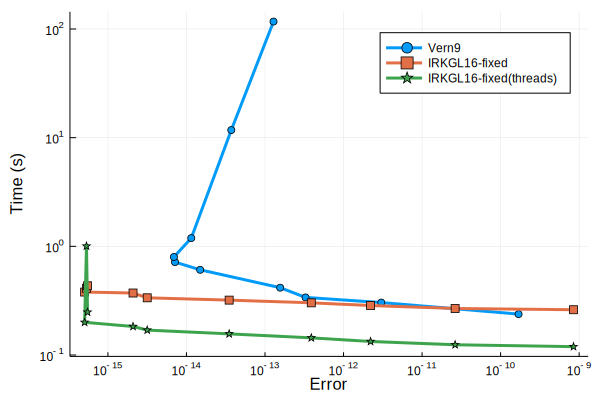

In [4]:
plot(wp2)

### Float64 (SecondOrderProblem)

In [12]:
setups = [
          Dict(:alg=>DPRKN12())   
]
solnames = ["DPRKN12"]
wp3 = WorkPrecisionSet(prob2nd64,abstols,reltols,setups;appxsol=test_solx2nd,save_everystep=false,numruns=1,maxiters=10^9,names=solnames);

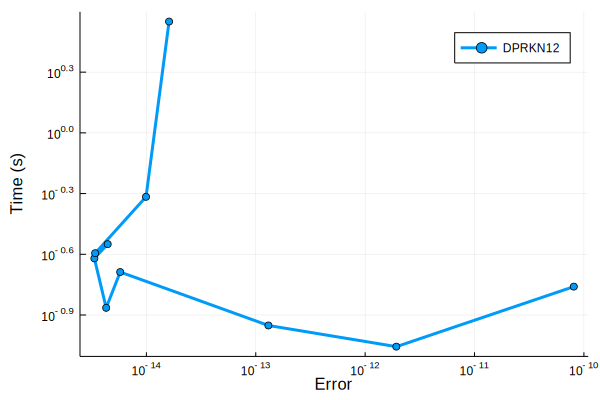

In [13]:
plot(wp3)

### Plot: OdeProblem+DynamicalProblem+SecondOrderProblem (Float64)

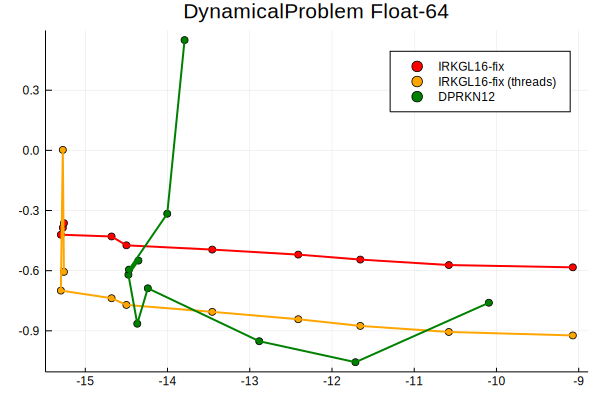

In [14]:
plot(title="DynamicalProblem Float-64")
#k=1
#plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="Vern9", color="blue")
#plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="",lw=2, color="blue")
# 
k=2
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="IRKGL16-fix",color="red")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="", lw=2, color="red")
#
k=3
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="IRKGL16-fix (threads)",color="orange")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="", lw=2, color="orange")
#
k=1
plot!(log10.(wp3.wps[k].errors),log10.(wp3.wps[k].times), seriestype=:scatter, label="DPRKN12",color="green")
plot!(log10.(wp3.wps[k].errors),log10.(wp3.wps[k].times), label="", lw=2, color="green")

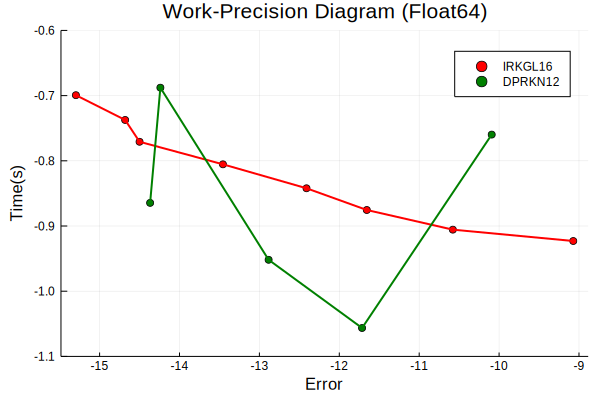

In [56]:
plot(title="Work-Precision Diagram (Float64)", xlabel="Error",ylabel="Time(s)",ylimit=(-1.1,-0.6),size= (600,400))
k=3
plot!(log10.(wp2.wps[k].errors[1:8]),log10.(wp2.wps[k].times[1:8]), seriestype=:scatter, label="IRKGL16",color="red")
plot!(log10.(wp2.wps[k].errors[1:8]),log10.(wp2.wps[k].times[1:8]), label="", lw=2, color="red")
#
k=1
plot!(log10.(wp3.wps[k].errors[1:5]),log10.(wp3.wps[k].times[1:5]), seriestype=:scatter, label="DPRKN12",color="green")
plot!(log10.(wp3.wps[k].errors[1:5]),log10.(wp3.wps[k].times[1:5]), label="", lw=2, color="green")

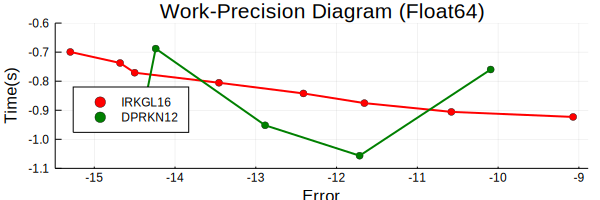

In [60]:
plot(title="Work-Precision Diagram (Float64)", xlabel="Error",ylabel="Time(s)",ylimit=(-1.1,-0.6),size=(600,200),legend=:bottomleft)
k=3
plot!(log10.(wp2.wps[k].errors[1:8]),log10.(wp2.wps[k].times[1:8]), seriestype=:scatter, label="IRKGL16",color="red")
plot!(log10.(wp2.wps[k].errors[1:8]),log10.(wp2.wps[k].times[1:8]), label="", lw=2, color="red")
#
k=1
plot!(log10.(wp3.wps[k].errors[1:5]),log10.(wp3.wps[k].times[1:5]), seriestype=:scatter, label="DPRKN12",color="green")
plot!(log10.(wp3.wps[k].errors[1:5]),log10.(wp3.wps[k].times[1:5]), label="", lw=2, color="green")

In [15]:
#
# Vern9     tol=1e-13
#
fieldnames(typeof(wp3))
fieldnames(typeof(wp3.wps[1]))
(wp3.wps[1].errors[4],wp3.wps[1].abstols[4],wp3.wps[1].times[4])

(5.76353826638031e-15, 1.0e-13, 0.205198344)

In [20]:
#
# IRKGL16    dt=5.85
#
fieldnames(typeof(wp2.wps[3]))
(wp2.wps[3].errors[8],dts[8],wp2.wps[3].times[8])

(5.049033816698184e-16, 5.8444712523555555, 0.19982986)

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float128)

In [17]:
#now()

In [18]:
#setprecision(BigFloat, 108)
#abstols = 1.0 ./ 10.0 .^ (12:30)
#reltols = 1.0 ./ 10.0 .^ (12:30)

#dts=16*0.866.^(0:length(reltols)-1);

### Float128 (OdeProblem)

In [19]:
#setups = [ Dict(:alg=>Vern9())
#           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>false) 
#           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>false,:threading=>true) 
#           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>true,:low_prec_type=>Float64)
#           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>true,:low_prec_type=>Float64,:threading=>true)
#           Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>false) 
#           Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>false,:threading=>true) 
#           Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>true,:low_prec_type=>Float64)
#           Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>true,:low_prec_type=>Float64,:threading=>true)
#]
#solnames = ["Vern9","IRKGL16-adaptive","IRKGL16-adaptive/threads","IRKGL16-adaptive/Mix","IRKGL16-adaptive/Mix/thread","IRKGL16-fix","IRKGL16-fix/threads","IRKGL16-fix/Mix","IRKGL16-fix/Mix/thread"]
#wp11 = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=1,maxiters=10^9);

In [20]:
#plot(wp11)

### Float128 (DynamicalProblem)

In [21]:
#setups = [
#          Dict(:alg=>Vern9())
#          Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>false)
#          Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>false, :threading=>true)
#          Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>false) 
#          Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>false,:threading=>true) 
#]
#solnames = ["Vern9", "IRKGL16-adaptive", "IRKGL16-fix", "IRKGL16-fix/thread"]
#wp12 = WorkPrecisionSet(probdyn128,abstols,reltols,setups;appxsol=test_solx,save_everystep=false,numruns=1,maxiters=10^9,name=solnames);

In [22]:
#plot(wp12)

### Float128 (SecondOrderProblem)

In [23]:
#setups = [
#          Dict(:alg=>DPRKN12())   
#]
#solname=["DPRKN12"]
#wp13 = WorkPrecisionSet(prob2nd128,abstols,reltols,setups;appxsol=test_solx2nd,save_everystep=false,numruns=1,maxiters=10^9, names=solname);

In [24]:
#plot(wp13)

### Plot: OdeProblem+DynamicalProblem+SecondOrderProblem

In [25]:
#k=1
#plot(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="Vern9 (OdeProblem)")
#plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="")
# 
#k=1
#plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="Vern9 (DynamicProblem)")
#plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="")


In [26]:
#k=9
#plot(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16 (OdeProblem)", color="red")
#plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="", color="red")
#
#k=5
#plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="IRKGL16 (DynamicProblem)",  color="green")
#plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="", color="green")

In [27]:
#k=1
#plot(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="Vern9 (DynamicProblem)", color="blue")
#plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="",color="blue")
#
#k=9
#plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16-MIX (OdeProblem)", color="red")
#plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="", color="red")
#
#k=1
#plot!(log10.(wp13.wps[k].errors),log10.(wp13.wps[k].times), seriestype=:scatter, label="DPRKN12 (2OdeProblem)", color="green")
#plot!(log10.(wp13.wps[k].errors),log10.(wp13.wps[k].times), label="", color="green")

<a href="#top">Back to the top</a>

### Save Data

In [28]:
# Float64 experiments
@save "./Data/output/OutNBody9_wp2.jld2" wp2
@save "./Data/output/OutNBody9_wp3.jld2" wp3
# Float128 experiments
#@save "./Data/output/OutNBody9_wp11.jld2" wp11
#@save "./Data/output/OutNBody9_wp12.jld2" wp12
#@save "./Data/output/OutNBody9_wp13.jld2" wp13

In [3]:
# Float64 experiments
@load "./Data/output/OutNBody9_wp2.jld2" wp2
@load "./Data/output/OutNBody9_wp3.jld2" wp3
# Float128 experiments
#@load "./Data/output/OutNBody9_wp11.jld2" wp11
#@load "./Data/output/OutNBody9_wp12.jld2" wp12
#@load "./Data/output/OutNBody9_wp13.jld2" wp13

┌ Warning: read type ODEFunction{true,typeof(NbodyODEq!),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing} has a different number of parameters from type ODEFunction in workspace; reconstructing
└ @ JLD2 /home/joseba/.julia/packages/JLD2/2W9VX/src/data.jl:1152
┌ Warning: read type ODEFunction{true,typeof(NbodyODEv!),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing} has a different number of parameters from type ODEFunction in workspace; reconstructing
└ @ JLD2 /home/joseba/.julia/packages/JLD2/2W9VX/src/data.jl:1152
┌ Warning: read type DynamicalODEFunction{true,JLD2.ReconstructedTypes.var"##ODEFunction{true,typeof(NbodyODEq!),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing}#253",JLD2.ReconstructedTypes.var"##ODEFunction{true,typeof(NbodyODEv!),UniformScaling{Bool},Nothing,Nothing,Not

1-element Array{Symbol,1}:
 :wp3

In [30]:
now()

2020-07-08T21:28:15.862